# DA023 Preprocess
01/30/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA023'
subj_format = ['edf']
subj_site = ['UCD']


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/raw/DA023_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 983039  =      0.000 ...  1919.998 secs...


In [8]:
mne_data

<RawEDF | DA023_SWB.edf, 174 x 983040 (1920.0 s), ~1.27 GB, data loaded>

In [13]:
mne_data.ch_names

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LAM10',
 'LAM11',
 'LAM12',
 'LAM13',
 'LAM14',
 'LAM15',
 'LAM16',
 'LAH1',
 'LAH2',
 'LAH3',
 'LAH4',
 'LAH5',
 'LAH6',
 'LAH7',
 'LAH8',
 'LAH9',
 'LAH10',
 'LAH11',
 'LAH12',
 'LAH13',
 'LAH14',
 'LAH15',
 'LAH16',
 'LPMTG1',
 'LPMTG2',
 'LPMTG3',
 'LPMTG4',
 'LPMTG5',
 'LPMTG6',
 'LPMTG7',
 'LPMTG8',
 'LPMTG9',
 'LPMTG10',
 'LASTG1',
 'LASTG2',
 'LASTG3',
 'LASTG4',
 'LASTG5',
 'LASTG6',
 'LASTG7',
 'LASTG8',
 'LASTG9',
 'LASTG10',
 'LMSTG1',
 'LMSTG2',
 'LMSTG3',
 'LMSTG4',
 'LMSTG5',
 'LMSTG6',
 'LMSTG7',
 'LMSTG8',
 'LMSTG9',
 'LMSTG10',
 'LPSTG1',
 'LPSTG2',
 'LPSTG3',
 'LPSTG4',
 'LPSTG5',
 'LPSTG6',
 'LPSTG7',
 'LPSTG8',
 'LPSTG9',
 'LPSTG10',
 'LSMG1',
 'LSMG2',
 'LSMG3',
 'LSMG4',
 'LSMG5',
 'LSMG6',
 'LSMG7',
 'LSMG8',
 'LSMG9',
 'LSMG10',
 'LANG1',
 'LANG2',
 'LANG3',
 'LANG4',
 'LANG5',
 'LANG6',
 'LANG7',
 'LANG8',
 'LANG9',
 'LANG10',
 'LPB1',
 'LPB2',
 'LPB3',
 'LPB4',
 'LPB5',
 'LPB6'

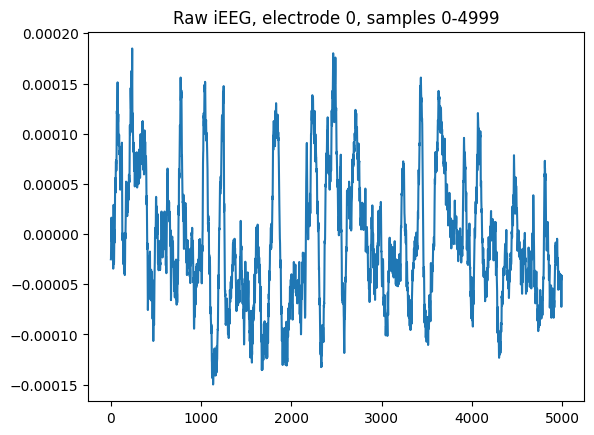

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 171 out of 174 | elapsed:    7.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:    7.5s finished


<RawEDF | DA023_SWB.edf, 174 x 960000 (1920.0 s), ~1.24 GB, data loaded>

### Photodiode
- examine photodiode 

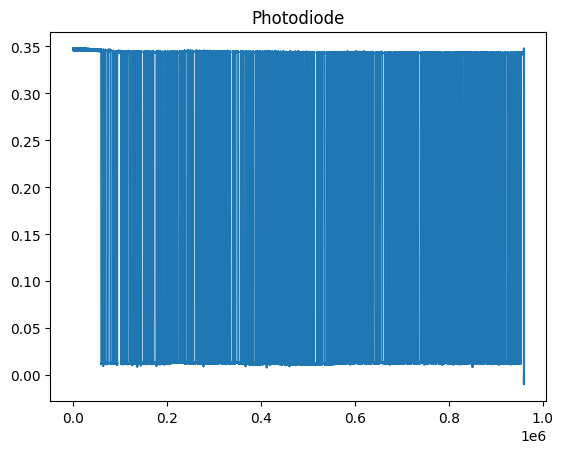

In [14]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("PHOTODIODE")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [15]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='PHOTODIODE', overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/photodiode.fif
[done]


In [16]:
mne_data.drop_channels(['PHOTODIODE'])

<RawEDF | DA023_SWB.edf, 173 x 960000 (1920.0 s), ~1.24 GB, data loaded>

### Notch filter line noise

In [17]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    6.0s finished


<RawEDF | DA023_SWB.edf, 173 x 960000 (1920.0 s), ~1.24 GB, data loaded>

### Anatomical Localization

In [18]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | DA023_SWB.edf, 173 x 960000 (1920.0 s), ~1.24 GB, data loaded>

In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0     LAC1     A32p_L  -2.948270  35.165349  28.967987  -3.244003  29.783249   
1    LAC10     A8dl_L -17.340510  32.767711  56.937081 -18.622061  32.069451   
2    LAC11     A8dl_L -19.339433  32.368105  60.133549 -20.763493  32.332690   
3    LAC12     A8dl_L -20.938571  31.968499  62.930459 -22.441373  32.456241   
4    LAC13    Unknown -22.537708  31.968499  65.727368 -24.123625  33.000428   
..     ...        ...        ...        ...        ...        ...        ...   
145  LSMG5     A40c_L -53.720895 -36.763783  29.367546 -54.075538 -48.517991   
146  LSMG6     A40c_L -57.318955 -36.364177  30.166663 -57.724920 -47.936912   
147  LSMG7     A40c_L -60.517231 -36.364177  30.965780 -60.975772 -47.795985   
148  LSMG8     A40c_L -63.715506 -35.964570  31.764897 -64.342587 -47.285110   
149  LSMG9    Unknown -68.113135 -35.964570  32.564014 -69.044117 -47.225548   

         mni_z       gm                                 NMM            Anat  \
0    18.898609     Gray  Left ACgG anterior cingulate gyrus         Area 33   
1    49.930015     Gray     Left SFG superior frontal gyrus         Unknown   
2    53.556836     Gray     Left SFG superior frontal gyrus         Unknown   
3    56.694248     Gray     Left SFG superior frontal gyrus         Unknown   
4    59.764154  Unknown                             Unknown         Unknown   
..         ...      ...                                 ...             ...   
145  33.446039     Gray        Left SMG supramarginal gyrus  Area PFm (IPL)   
146  34.325547     Gray        Left SMG supramarginal gyrus  Area PFm (IPL)   
147  35.269393     Gray        Left SMG supramarginal gyrus  Area PFm (IPL)   
148  36.142847  Unknown        Left SMG supramarginal gyrus  Area PFm (IPL)   
149  37.149103  Unknown                             Unknown         Unknown   

                    AnatMacro    BN246                            YBA_1  \
0                       L ACC     L CG           Left cingulate gyrus G   
1    L Superior Frontal Gyrus    L SFG                          Unknown   
2    L Superior Frontal Gyrus    L SFG  Left superior frontal gyrus 4 D   
3    L Superior Frontal Gyrus    L SFG  Left superior frontal gyrus 4 D   
4                     Unknown  Unknown  Left superior frontal gyrus 4 D   
..                        ...      ...                              ...   
145     L SupraMarginal Gyrus    L IPL     Left supramarginal gyrus 3 B   
146     L SupraMarginal Gyrus    L IPL     Left supramarginal gyrus 3 B   
147     L SupraMarginal Gyrus    L IPL     Left supramarginal gyrus 3 B   
148                   Unknown    L IPL     Left supramarginal gyrus 3 B   
149                   Unknown  Unknown                          Unknown   

                   ManualExamination  
0                                NaN  
1    Left superior frontal gyrus 4 D  
2                                NaN  
3                                OOB  
4                                OOB  
..                               ...  
145                              NaN  
146                              NaN  
147                              NaN  
148                              OOB  
149                              OOB  

[150 rows x 15 columns]

In [10]:
list(elec_locs.label)

['LAC1',
 'LAC10',
 'LAC11',
 'LAC12',
 'LAC13',
 'LAC14',
 'LAC15',
 'LAC16',
 'LAC2',
 'LAC3',
 'LAC4',
 'LAC5',
 'LAC6',
 'LAC7',
 'LAC8',
 'LAC9',
 'LAH1',
 'LAH10',
 'LAH11',
 'LAH12',
 'LAH13',
 'LAH14',
 'LAH15',
 'LAH16',
 'LAH2',
 'LAH3',
 'LAH4',
 'LAH5',
 'LAH6',
 'LAH7',
 'LAH8',
 'LAH9',
 'LAM1',
 'LAM10',
 'LAM11',
 'LAM12',
 'LAM13',
 'LAM14',
 'LAM15',
 'LAM16',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LANG1',
 'LANG10',
 'LANG2',
 'LANG3',
 'LANG4',
 'LANG5',
 'LANG6',
 'LANG7',
 'LANG8',
 'LANG9',
 'LASTG1',
 'LASTG10',
 'LASTG2',
 'LASTG3',
 'LASTG4',
 'LASTG5',
 'LASTG6',
 'LASTG7',
 'LASTG8',
 'LASTG9',
 'LMC1',
 'LMC10',
 'LMC11',
 'LMC12',
 'LMC13',
 'LMC14',
 'LMC15',
 'LMC16',
 'LMC2',
 'LMC3',
 'LMC4',
 'LMC5',
 'LMC6',
 'LMC7',
 'LMC8',
 'LMC9',
 'LMSTG1',
 'LMSTG10',
 'LMSTG2',
 'LMSTG3',
 'LMSTG4',
 'LMSTG5',
 'LMSTG6',
 'LMSTG7',
 'LMSTG8',
 'LMSTG9',
 'LOCC1',
 'LOCC10',
 'LOCC2',
 'LOCC3',
 'LOCC4',
 'LOCC5',
 'LOCC6',
 '

In [11]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

[]


In [12]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [13]:
unmatched_seeg #make sure there are no unmatched names


[]

In [14]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [15]:
new_name_dict #make sure this passes the eye test 


{'lam1': 'lam1',
 'lam2': 'lam2',
 'lam3': 'lam3',
 'lam4': 'lam4',
 'lam5': 'lam5',
 'lam6': 'lam6',
 'lam7': 'lam7',
 'lam8': 'lam8',
 'lam9': 'lam9',
 'lam10': 'lam10',
 'lam11': 'lam11',
 'lam12': 'lam12',
 'lam13': 'lam13',
 'lam14': 'lam14',
 'lam15': 'lam15',
 'lam16': 'lam16',
 'lah1': 'lah1',
 'lah2': 'lah2',
 'lah3': 'lah3',
 'lah4': 'lah4',
 'lah5': 'lah5',
 'lah6': 'lah6',
 'lah7': 'lah7',
 'lah8': 'lah8',
 'lah9': 'lah9',
 'lah10': 'lah10',
 'lah11': 'lah11',
 'lah12': 'lah12',
 'lah13': 'lah13',
 'lah14': 'lah14',
 'lah15': 'lah15',
 'lah16': 'lah16',
 'lpmtg1': 'lpmtg1',
 'lpmtg2': 'lpmtg2',
 'lpmtg3': 'lpmtg3',
 'lpmtg4': 'lpmtg4',
 'lpmtg5': 'lpmtg5',
 'lpmtg6': 'lpmtg6',
 'lpmtg7': 'lpmtg7',
 'lpmtg8': 'lpmtg8',
 'lpmtg9': 'lpmtg9',
 'lpmtg10': 'lpmtg10',
 'lastg1': 'lastg1',
 'lastg2': 'lastg2',
 'lastg3': 'lastg3',
 'lastg4': 'lastg4',
 'lastg5': 'lastg5',
 'lastg6': 'lastg6',
 'lastg7': 'lastg7',
 'lastg8': 'lastg8',
 'lastg9': 'lastg9',
 'lastg10': 'lastg10',
 'lm

In [16]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<Raw | raw_ieeg.fif, 150 x 960000 (1920.0 s), ~1.07 GB, data loaded>

In [19]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 150 left sEEG and 0 right sEEG electrodes
We have a total of 150 sEEG electrodes


In [20]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<Raw | raw_ieeg.fif, 150 x 960000 (1920.0 s), ~1.07 GB, data loaded>

In [21]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<Raw | raw_ieeg.fif, 150 x 960000 (1920.0 s), ~1.07 GB, data loaded>

In [22]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<Raw | raw_ieeg.fif, 150 x 960000 (1920.0 s), ~1.07 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [23]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [24]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [25]:
probe_ch_counts

{'lac': 16,
 'lah': 16,
 'lam': 16,
 'lang': 10,
 'lastg': 10,
 'lmc': 16,
 'lmstg': 10,
 'locc': 10,
 'lpb': 16,
 'lpmtg': 10,
 'lpstg': 10,
 'lsmg': 10}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [26]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lac12',
 'lac2',
 'lah1',
 'lmc12',
 'lmc13',
 'lmc14',
 'lmc15',
 'lmc16',
 'lmc9',
 'lpmtg3',
 'lpstg9']

<IPython.core.display.Javascript object>


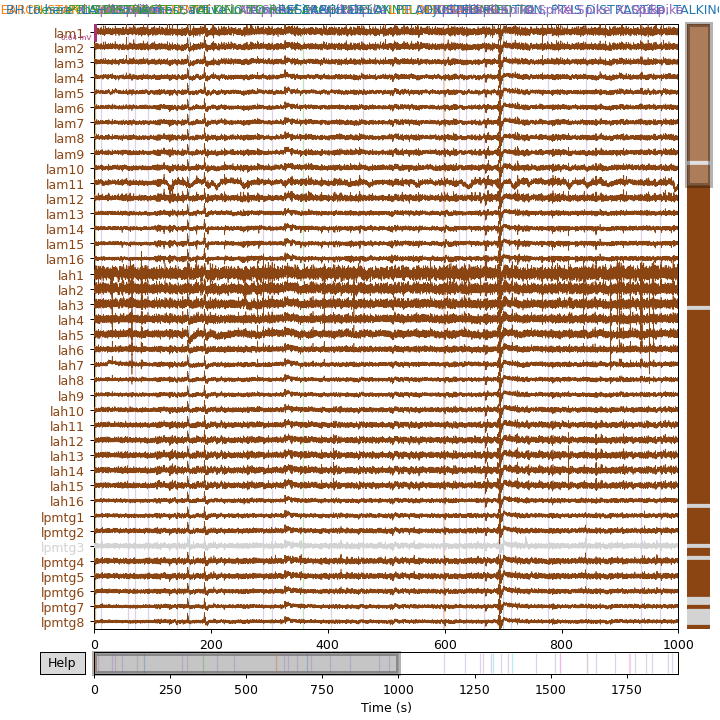

In [18]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/30)


In [16]:
mne_data.info['bads'] = ['lpmtg3','lpstg9',
 'lac12',
 'lac15',
 'lmc9',
 'lmc12',
 'lmc15',
 'lmc13',
 'lmc14',
 'lmc10',
 'lac2']

In [17]:
mne_data.info['bads']

['lpmtg3',
 'lpstg9',
 'lac12',
 'lac15',
 'lmc9',
 'lmc12',
 'lmc15',
 'lmc13',
 'lmc14',
 'lmc10',
 'lac2']

In [19]:
mne_data.info #sanity check that bads info saved

<Info | 12 non-empty values
 bads: 11 items (lpmtg3, lpstg9, lac12, lac15, lmc9, lmc12, lmc15, ...)
 ch_names: lam1, lam2, lam3, lam4, lam5, lam6, lam7, lam8, lam9, lam10, ...
 chs: 150 sEEG
 custom_ref_applied: False
 dig: 150 items (150 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2023-03-31 14:14:25 UTC
 meas_id: 4 items (dict)
 nchan: 150
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [20]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [21]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=28, n_times=960000
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Added the following bipolar channels:
lac1-lac3, lac3-lac4, lac4-lac5, lac5-lac6, lac9-lac10, lac10-lac11, lah1-lah2, lah2-lah3, lah5-lah6, lah10-lah11, lah11-lah12, lah12-lah13, lah13-lah14, lah14-lah15, lah15-lah16, lam1-lam2, lam2-lam3, lam3-lam4, lam4-lam5, lam10-lam11, lang6-lang7, lang7-lang8, lastg5-lastg6, lmc3-lmc4, lpb9-lpb10, lpmtg5-lpmtg6, lsmg5-lsmg6, lsmg6-lsmg7


In [22]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 28 x 960000 (1920.0 s), ~205.2 MB, data loaded>

In [23]:
mne_data_bp_reref.ch_names

['lac1-lac3',
 'lac3-lac4',
 'lac4-lac5',
 'lac5-lac6',
 'lac9-lac10',
 'lac10-lac11',
 'lah1-lah2',
 'lah2-lah3',
 'lah5-lah6',
 'lah10-lah11',
 'lah11-lah12',
 'lah12-lah13',
 'lah13-lah14',
 'lah14-lah15',
 'lah15-lah16',
 'lam1-lam2',
 'lam2-lam3',
 'lam3-lam4',
 'lam4-lam5',
 'lam10-lam11',
 'lang6-lang7',
 'lang7-lang8',
 'lastg5-lastg6',
 'lmc3-lmc4',
 'lpb9-lpb10',
 'lpmtg5-lpmtg6',
 'lsmg5-lsmg6',
 'lsmg6-lsmg7']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


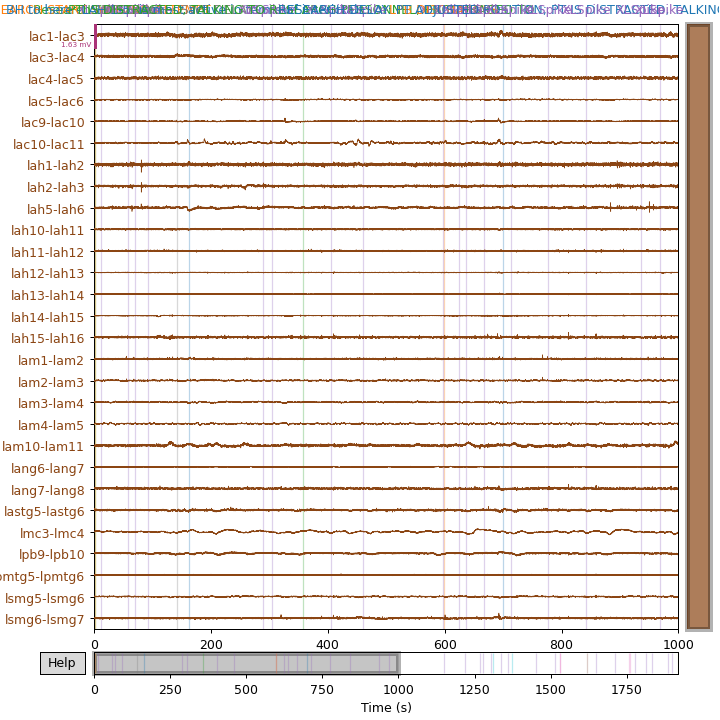

In [24]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


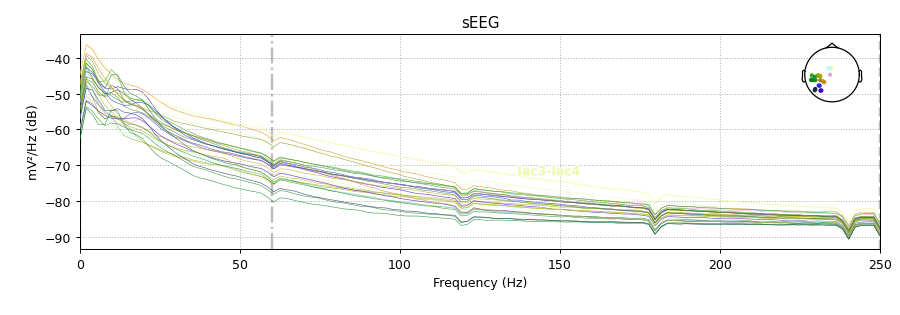

<IPython.core.display.Javascript object>


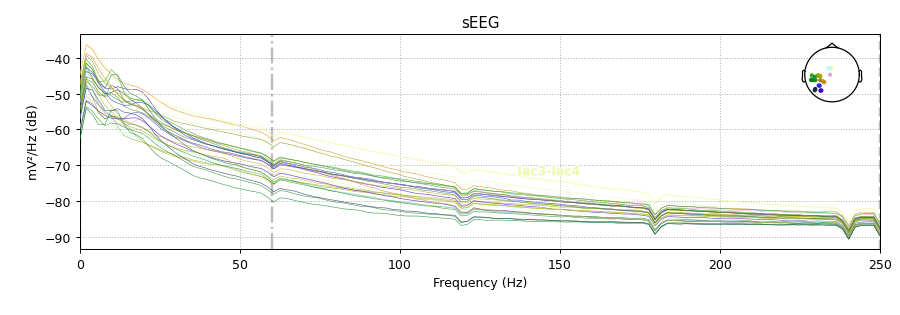

In [25]:
mne_data_bp_reref.compute_psd().plot()

In [26]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif
[done]


## Save mne_data

In [27]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [245]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [6]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/photodiode.fif...
Isotrak not found
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...


In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 960000 (1920.0 s), ~7.3 MB, data loaded>

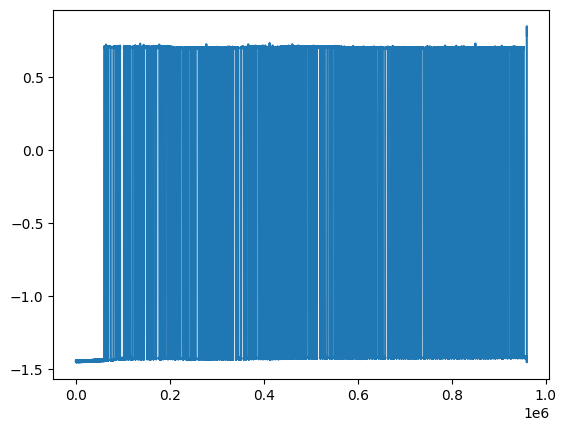

In [12]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))

In [11]:
temp_diode = photodiode_data.copy()
temp_data = -temp_diode._data[0,:]
temp_diode._data = temp_data
# temp_data = temp_diode._data[0,:]
# temp_data[0:450000] = 0
# temp_data[570000:] = 0
# temp_data[temp_data>4000] = 0
# temp_data = np.abs(temp_data-np.nanmax(temp_data)) #consider resaving photodiode 
# temp_data = np.abs(temp_diode._data[0, :])
# temp_data[0:1250000] = 0


In [45]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.5

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 157 pulses


In [46]:
print(slope, offset,smoothSize,windSize,height)

0.999997473651329 -22.281960639352462 11 15 0.5


In [47]:
[(x*slope + offset) for x in beh_ts]

[204.3848929669371,
 212.5898886785274,
 223.904680755075,
 242.36523212644335,
 254.33553898946872,
 265.32799027868367,
 281.81376196068277,
 290.234425217561,
 303.9038038327712,
 319.84612019764836,
 330.59966670564785,
 342.1631581003372,
 362.1268700053951,
 371.8557062232925,
 379.6547278512311,
 394.8121190038143,
 403.06612699461425,
 412.3288971957506,
 426.0144198155965,
 435.93502245108607,
 444.1582057251652,
 459.0827534795886,
 467.5244366762835,
 475.74958056441113,
 492.73377453894983,
 501.81069156723214,
 509.6930498735225,
 528.8342295722091,
 539.6389571863094,
 548.9108955791824,
 562.4861398028102,
 572.1901864044371,
 581.464299768187,
 591.7884274264306,
 602.1508846797144,
 612.3022301529788,
 628.5557963873157,
 637.6052781308938,
 646.2887148700931,
 660.8073151648016,
 669.49821206776,
 683.1991683792489,
 703.3213531269939,
 716.522293464365,
 724.8985469698582,
 737.1236189714032,
 746.6616332388185,
 755.9844697731248,
 768.4090755552972,
 779.7367689774

In [214]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [48]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [49]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [50]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [51]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif...
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.7s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 28 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif...
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.5s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 28 columns


In [52]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~48.2 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~112.3 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [53]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [54]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [55]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 86 columns
Replacing existing metadata with 86 columns


In [56]:
epochs_all_evs[event].metadata

lac1-lac3 lac3-lac4 lac4-lac5 lac5-lac6 lac9-lac10 lac10-lac11 lah1-lah2  \
0         NaN     noise       NaN       NaN        NaN         NaN       NaN   
1         NaN       NaN       NaN       NaN        NaN         NaN       NaN   
2         NaN       NaN       NaN       NaN        NaN         NaN       NaN   
3         NaN       NaN       NaN       NaN        NaN         NaN       NaN   
4       noise       NaN       NaN       NaN        NaN         NaN       NaN   
..        ...       ...       ...       ...        ...         ...       ...   
145       NaN       NaN       NaN       NaN        NaN         NaN       NaN   
146       NaN       NaN       NaN       NaN        NaN         NaN       NaN   
147       NaN       NaN       NaN       NaN        NaN         NaN       NaN   
148       NaN       NaN       NaN       NaN        NaN         NaN     noise   
149       NaN       NaN       NaN       NaN        NaN         NaN       NaN   

    lah2-lah3   lah5-lah6 lah10-lah11  ... util_dCPE_emmap util_tCF_emmap  \
0         NaN         NaN         NaN  ...        0.231340       0.000000   
1         NaN         NaN         NaN  ...        0.109750       0.000000   
2         NaN         NaN         NaN  ...       -0.407867       0.558653   
3         NaN         NaN         NaN  ...       -0.206961       0.283472   
4         NaN         NaN         NaN  ...        1.283869      -1.283869   
..        ...         ...         ...  ...             ...            ...   
145       NaN         NaN         NaN  ...        0.038236       0.000000   
146       NaN  [1879.516]         NaN  ...        0.381403       0.000000   
147       NaN         NaN         NaN  ...        0.093982      -1.141278   
148       NaN         NaN         NaN  ...       -0.507422       0.782356   
149       NaN       noise         NaN  ...        0.219045       0.000000   

    util_dCF_emmap util_tRegret_emmap util_dRegret_emmap util_tRelief_emmap  \
0         0.307777           0.000000           0.000000           0.539117   
1         0.507422           0.000000           0.000000           0.617171   
2         0.407867          -0.558653          -0.407867           0.000000   
3         0.206961          -0.283472          -0.206961           0.000000   
4        -1.283869           0.000000           0.000000           1.283869   
..             ...                ...                ...                ...   
145       0.407867           0.000000           0.000000           0.446104   
146       0.507422           0.000000           0.000000           0.888825   
147      -1.141278           0.000000           0.000000           0.093982   
148       0.507422          -0.782356          -0.507422           0.000000   
149       0.407867           0.000000           0.000000           0.626913   

    util_dRelief_emmap util_RPE_emmap util_pRPE_emmap util_nRPE_emmap  
0             0.231340       0.000000             0.0        0.000000  
1             0.109750       0.000000             0.0        0.000000  
2             0.000000      -0.558653             0.0       -0.558653  
3             0.000000      -0.283472             0.0       -0.283472  
4             1.283869       0.000000             0.0        0.000000  
..                 ...            ...             ...             ...  
145           0.038236       0.000000             0.0        0.000000  
146           0.381403       0.000000             0.0        0.000000  
147           0.093982       0.000000             0.0        0.000000  
148           0.000000      -0.782356             0.0       -0.782356  
149           0.219045       0.000000             0.0        0.000000  

[150 rows x 86 columns]

### Save raw epoched data 

In [57]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [58]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [59]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [60]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [61]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [62]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 28, ~481.7 MB>}

In [63]:
power_epochs = {}

In [64]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 86 columns


In [65]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 28, ~2.35 GB>

In [66]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [67]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01312024


In [213]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif...
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...


-22.281960639352462


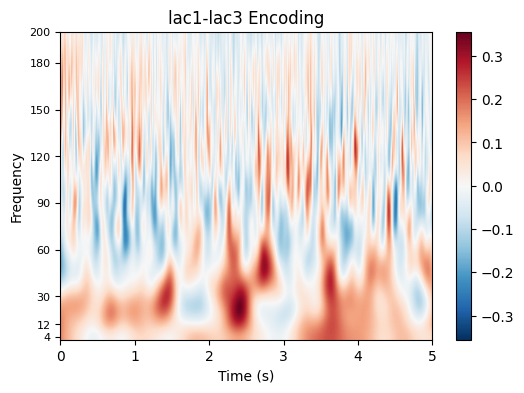

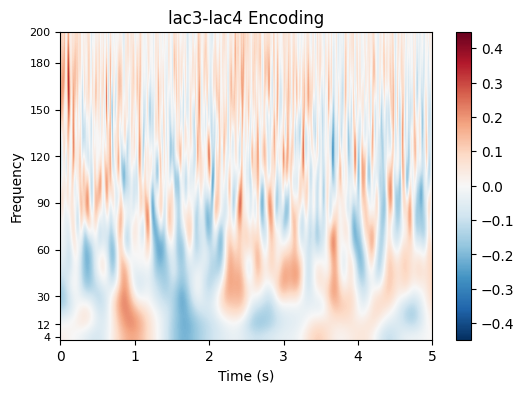

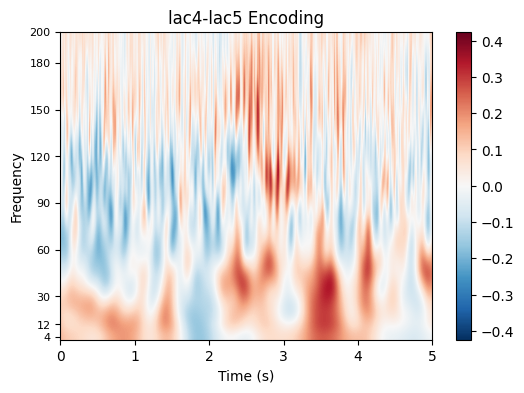

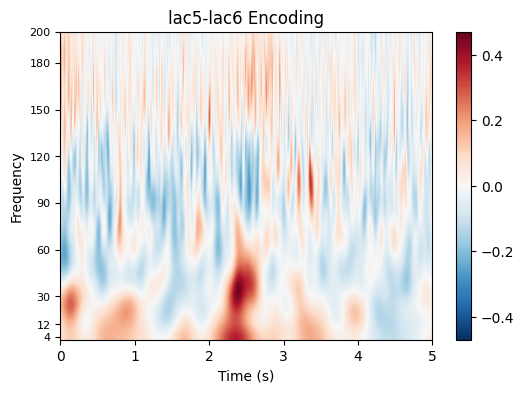

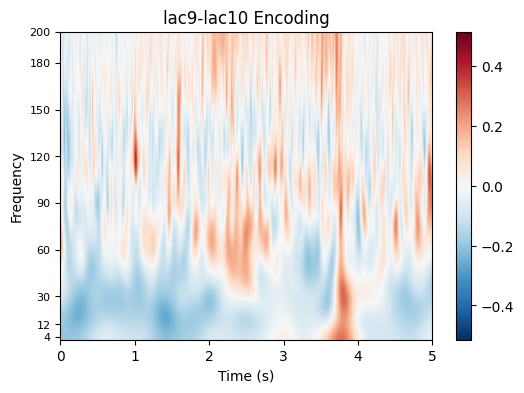

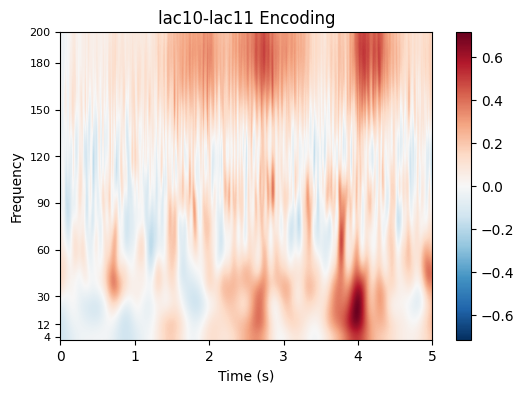

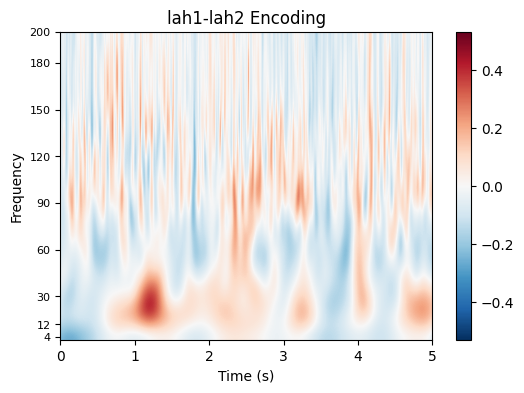

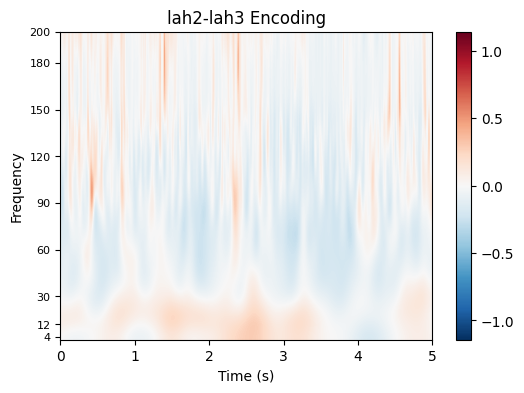

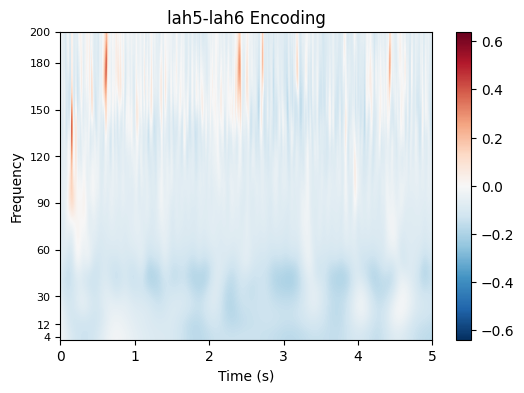

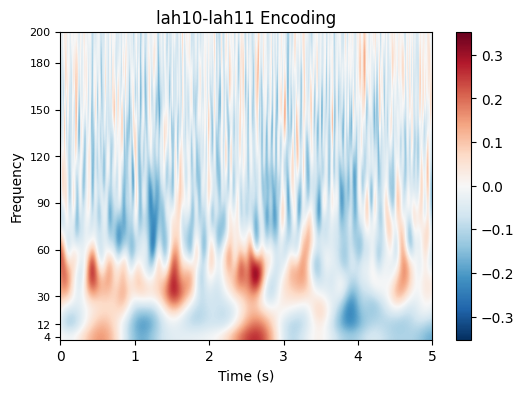

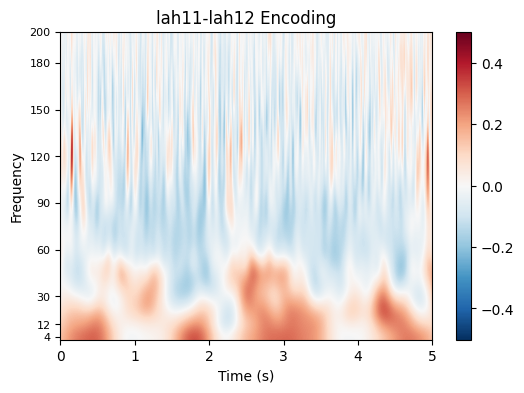

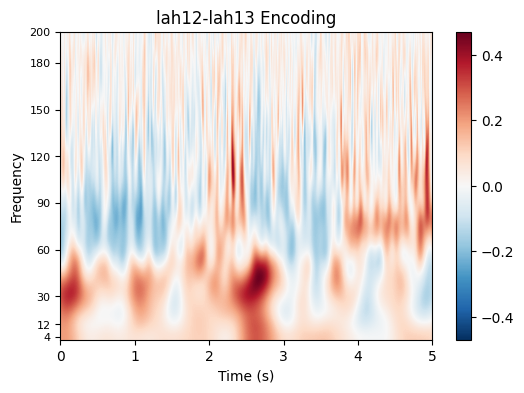

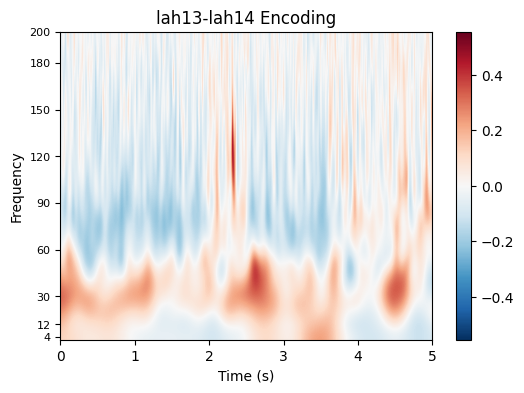

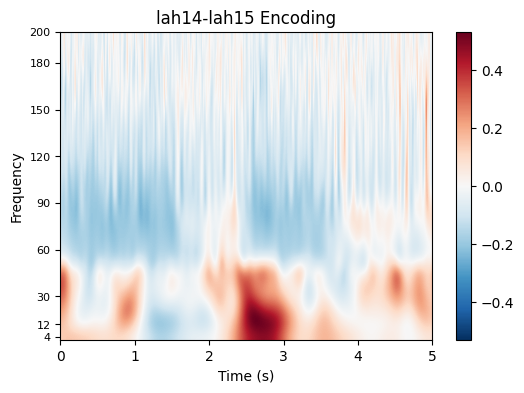

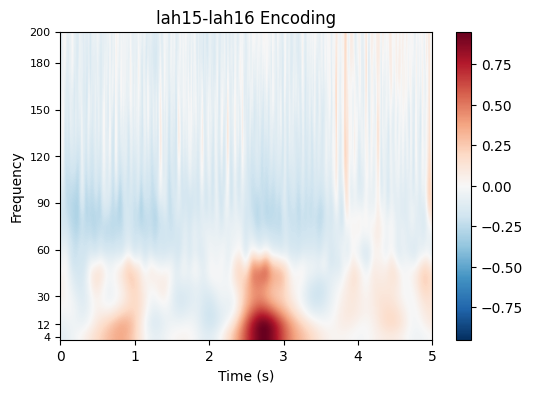

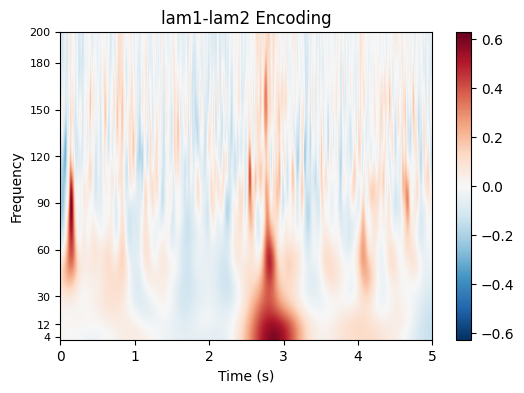

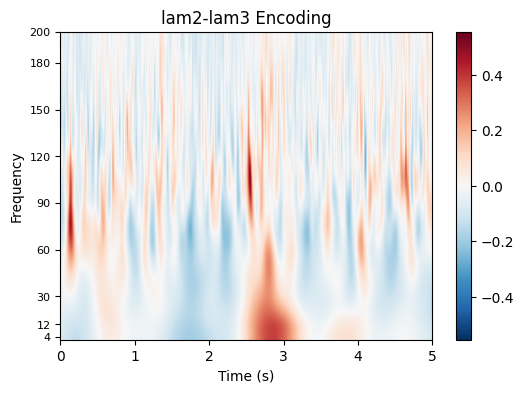

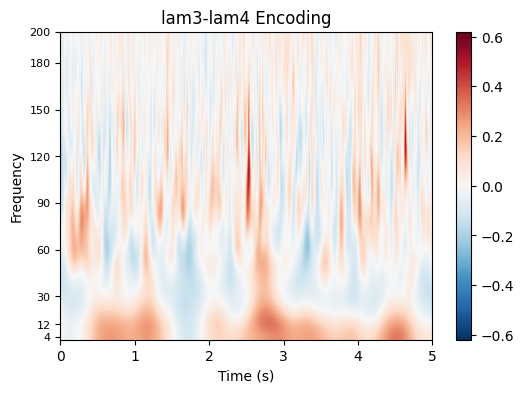

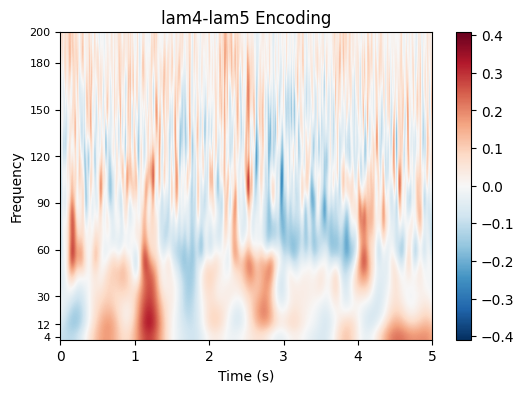

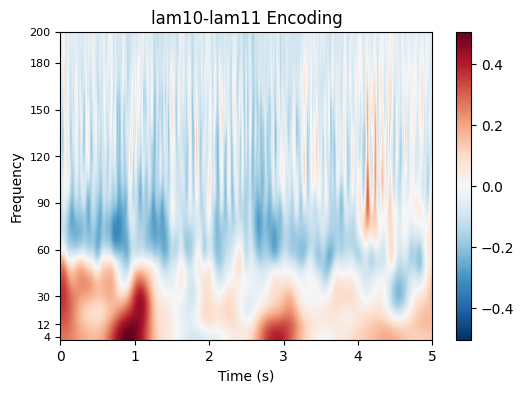

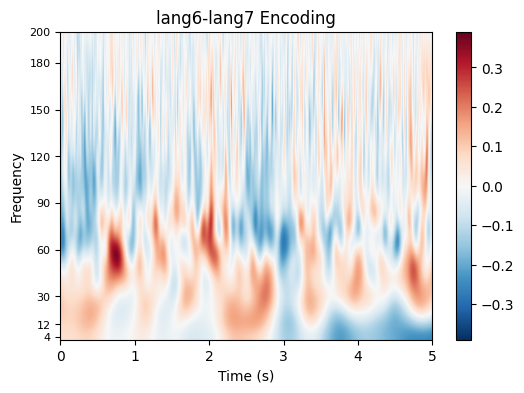

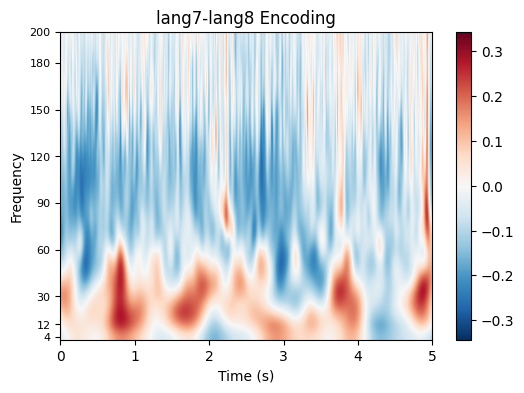

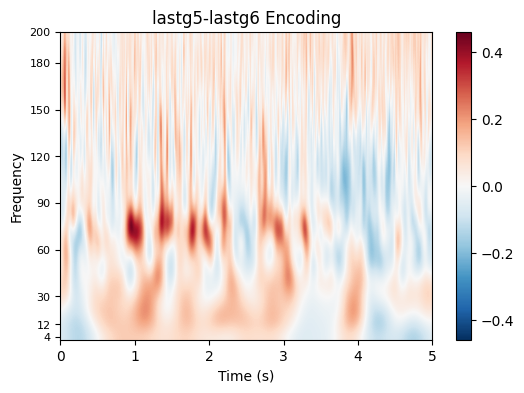

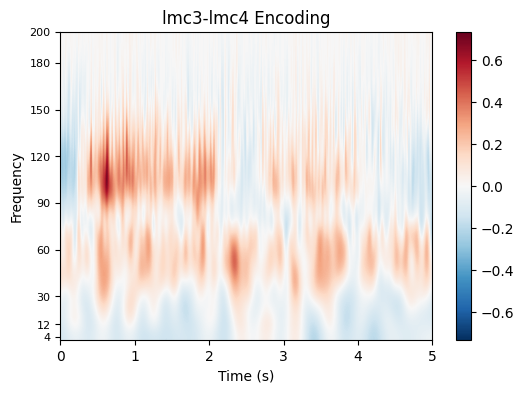

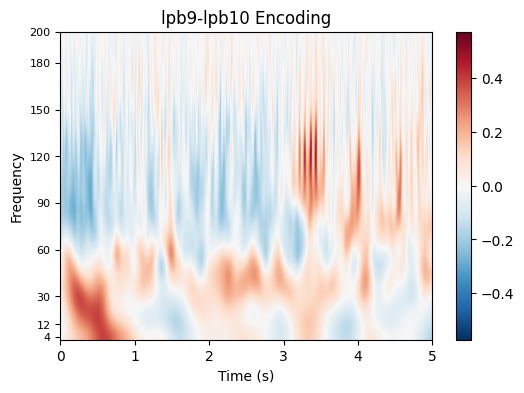

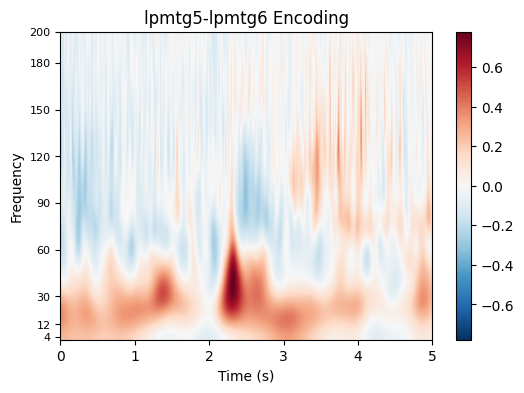

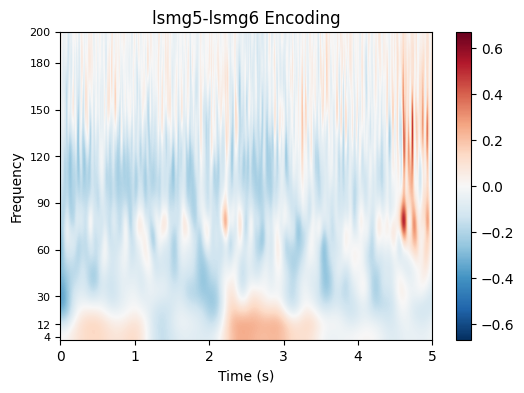

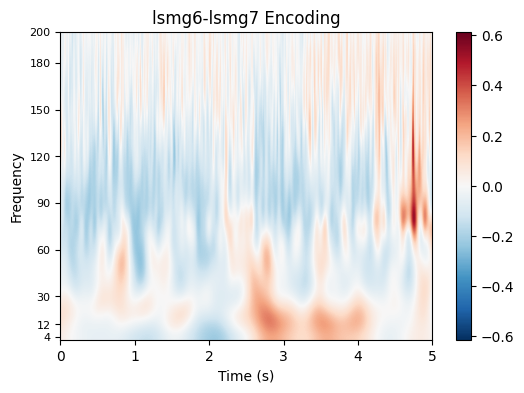

In [68]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
